# Extrapolation of trend

Some time series have marked upward or downward trends that continue over time. In this case, it may be reasonable to fit a curve to the past trend -interpolate- and extrapolate values to predict the future. Among the curves to be used are polynomial, exponential, logistic and Gompertz curves. In general, this method is recommended for estimating the long-term trend of a univariate series -as long as it verifies the above-. For this, it is recommended to have seven to ten years of data and not to generate predictions for a period longer than half of the past years for which data are available. This type of deterministic global trend is rarely encountered in practice, so the focus is on fitting trends locally in the series to extract short-term predictions. This short-term extrapolation is justified on the grounds that the underlying trend tends to change slowly over time compared to the prediction time horizon.

There is a drawback to this type of model: there is no logical basis for choosing between different curves, other than goodness of fit. In most cases several curves fit the series correctly, but give very different values when extrapolating. 

One way to estimate the trend -past and future- of a time series is to use classical regression methods to fit a curve to the observations. 

## Linear regression 

The multiple linear regression model assumes that a stochastic process $Y_t$ can be expressed according to the following expression:
$$
    Y_t = \beta_0 + \beta_1 X_{1, t} + ...+ \beta_k X_{k, t} + \varepsilon_t,
$$
where ${X_1, ..., X_k}$ are $k$ predictor variables or regressors, ${\beta_0, ..., \beta_k}$ are unknown parameters and ${\varepsilon_t}_{t=1}^n$ is the remaining series of residuals.

The following assumptions on the behaviour of the series are imposed:

- The stochastic process $\{Y_t, X_{1, t}, ..., X_{k, t} \}_{t=1}^n$ behaves linearly with respect to the parameters:
$$
    Y_t = \beta_0+ \beta_1 X_{1, t} + ...+ \beta_k X_{k, t} + \varepsilon_t.
$$
- No independent variable of the sample (and hence of the generating stochastic process) has to be constant over time or perfectly correlated (linear combination) with another regressor. This is the adaptation to time series of the hypothesis of independence between variables for classical regression. 

And the following conditions on the error series:
- The expected value of the error $\varepsilon_t$, knowing the regressors for all time periods, is zero $\forall t \in \{1, ..., n\}$, i.e. $E\left[\varepsilon_t | \mathbf{X}\right]$, where $\mathbf{X}$ denotes the set of predictor variables for all time periods (matrix $n \times k$). 
- There is no autocorrelation between any two error terms, conditional on $\mathbf{X}$: $\text{Corr}\left[\varepsilon_t, \varepsilon_s | \mathbf{X} \right]=0$, $\forall t \neq s$.=

It is also convenient that the distribution of errors is normal with constant variance $\sigma^{2}$ (independent of time). The difference between this assumption and the previous ones is that the previous ones are needed for the OLS to make sense, while this one is simply to simplify variance calculations of the estimators (especially for confidence intervals).

The predictor variables can be exogenous variables or time-dependent functions $t$. 
In this study, **the regression method is used to fit polynomial curves of order $d$**. That is: $X_{i, t}=t^{i}$, $i=1,...,d$. Linear regression models (linear models in the parameters) of this type are generally expressed as:

$$ 
Y_t = \beta_0 + \beta_1 t +\beta_2 t^2 +.... + \beta_d t^d + \varepsilon_t.
$$

# Setup

In [1]:
# data handling
import pandas as pd
import numpy as np

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['savefig.dpi'] = 300

# modeling
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from pmdarima.model_selection import train_test_split
from scipy.optimize import curve_fit
import statsmodels.api as sm
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.metrics import r2_score

from utils import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# set seed to replicate results
seed=123

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. 
For this analysis, only the variable 'Infected' is retained. 


The original series of infected persons has been transformed into a variable with greater epidemiological importance: the cumulative incidence series.
In addition, this transformation eliminates the seasonal pattern that was observed during the exploration of the original data. It was shown that this pattern was not the result of an inherent characteristic of the virus dynamics, but a consequence of the structure of the work calendar.

In [2]:
# read processed data
df = load_last_final_data(file_name='cumulative-incidence-14-days.csv')
df.head()

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\final-data\cumulative-incidence-14-days.csv


,Infected
Date,
2020-02-21,0.010685
2020-02-22,0.012821
2020-02-23,0.014958
2020-02-24,0.019232
2020-02-25,0.021369


To make this type of model comparable to other types of models, data is divided into train and test subsets. The first one will be used to explore and extract the characteristics of the model; the second will be used for evaluation.

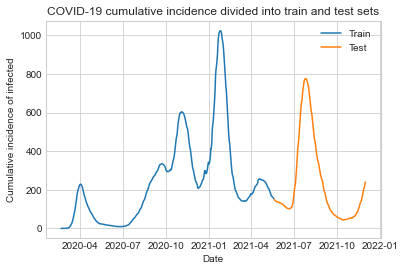

In [3]:
# divide data
train, test = train_test_split(df, test_size=0.3)
# show division
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('COVID-19 cumulative incidence divided into train and test sets')
plt.ylabel('Cumulative incidence of infected')
plt.xlabel('Date')
plt.legend()
plt.show()

# Polynomial Regression 

A class is defined to automate the process. Different types of curves are introduced, although only polynomial curves are finally studied.

In [4]:
class TrendExtrapolation:

    def __init__(self, window_size, steps_ahead, data,curve_type = 'poly', degree=1, metrics=metrics, eval_mode='WF'):
        # parameters
        self.window_size = window_size
        self.steps_ahead = steps_ahead
        self.degree = degree
        self.curve_type = curve_type

        # store raw data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data, eval_mode)
        self.baseline = self.get_baseline(self.train)

        # metrics to evaluate
        self.metrics = metrics
        self.train_r2 = []

    def train_test_split(self, data, eval_mode='WF'):
        """
        Split data into train and test subsets
        Args:
            data (pd.DataFrame or np.array): Data to be split
            eval_mode (str): Mode of evaluation, 'WF' for Walk Forward evaluation, 'MTTS' for Multiple Train Test Splits 
        Returns:
            train (numpy.ndarray): Train data
            test (numpy.ndarray): Test data
        """
        train, test = [], []

        if eval_mode == 'WF':
            # walk forward evaluation
                train.append(np.lib.stride_tricks.sliding_window_view(data[:-(self.steps_ahead)], window_shape=self.window_size))
                test.append(np.lib.stride_tricks.sliding_window_view(data[self.window_size:], window_shape=self.steps_ahead))

        elif eval_mode == 'MTTS':
            n_windows = data.shape[1]//(self.window_size+self.steps_ahead) # perfect windows 
            data_start_point = data.shape[1]%(self.window_size+self.steps_ahead) # data start to generate perfect windows sizes
            
            window = np.array(np.split(data[data_start_point:], n_windows))
            train.append(window[:, :-self.steps_ahead])
            test.append(window[:, -self.steps_ahead:])
        else:
            raise ValueError('Evaluation mode not recognized')

        return np.array(train)[0, :, :], np.array(test)[0, :, :]

    def get_baseline(self, train):
        baseline = []
        for window in train:
            baseline.append(np.repeat(window[-1], self.steps_ahead))           
        return np.array(baseline)

    models = {}

    def fit_predict(self, window, curve_type=None, degree=None, return_only_predictions=False, log_mode=None):
        if degree is None:
            degree = self.degree
        if curve_type is None:
            curve_type = self.curve_type
            
        if curve_type == 'spline_interp':
            return self.spline_interpolation_fit_predict(window, degree, log_mode, correct_predictions=True, return_only_predictions=return_only_predictions)
        if curve_type == 'poly':
            return self.poly_fit_predict(window, degree=degree, return_only_predictions=return_only_predictions,log_mode=log_mode)
        elif curve_type == 'exp':
            return self.exp_fit_predict(window,return_only_predictions)
        elif curve_type == 'logistic':
            return self.logistic_fit_predict(window,return_only_predictions)


    def spline_interpolation_fit_predict(self, window, degree=None, log_mode=None, correct_predictions=True, return_only_predictions=False):
        if degree is None:
            degree = self.degree

        # numberical index of the day
        x = np.arange(1,len(window)+1).ravel()
        # true data from window
        y = window.ravel()

        if log_mode == 'x':
            x = np.log(x)
        elif log_mode == 'y':
            y = np.log(y)
        elif log_mode == 'xy':
            x = np.log(x)
            y = np.log(y)

        # interpolate for some order k
        model = InterpolatedUnivariateSpline(x, y, k=degree)

        # predict
        x_present = np.arange(0, self.window_size)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)

        fitted = model(x_present)
        prediction = model(x_future)

        # store metrics of the fit
        self.train_r2.append(r2_score(y, fitted))

        if correct_predictions:
            # change negative predictions to zero
            prediction[prediction<0] = 0

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))

    def poly_fit_predict(self, window, degree=None, log_mode=None, correct_predictions=True, return_only_predictions=False):
        if degree is None:
            degree = self.degree

        # numberical index of the day
        x = np.arange(1,len(window)+1).reshape(-1,1)
        # true data from window
        y = window.reshape(-1,1)

        if log_mode == 'x':
            x = np.log(x)
        elif log_mode == 'y':
            y = np.log(y)
        elif log_mode == 'xy':
            x = np.log(x)
            y = np.log(y)

        # generate polynomials
        polynomial_features = PolynomialFeatures(degree=degree)
        # fit to time steps
        xp = polynomial_features.fit_transform(x)
        # fit regression
        # model = sm.OLS(y, xp).fit()
        model = sm.GLS(y, xp).fit()
        # store metrics of the fit
        self.train_r2.append(model.rsquared)

        # predict
        x_present = np.arange(0, self.window_size)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)
        x_present_transformed = polynomial_features.transform(x_present.reshape(-1,1))
        x_future_transformed = polynomial_features.transform(x_future.reshape(-1,1))

        fitted = model.predict(x_present_transformed)
        prediction = model.predict(x_future_transformed)
        pred_intervals = model.conf_int(x_future_transformed) # for pred intervals but lower limit is nan

        if correct_predictions:
            # change negative predictions to zero
            prediction[prediction<0] = 0

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))

    def exp_model(self, x, a, k, b):
        """Exponential function"""
        return a*np.exp(-k*x)+b

    def exp_fit_predict(self, window, return_only_predictions=False):
        """
        Fit exponential function to the window and predict 
        future values
        """
        x = np.arange(0, len(window)) # time mesh
        y = window.reshape(-1) # values of the series
        p0 = (1., 1e-6, 1.) # starting search coefs
        assert len(y.shape)==1

        # fit the exp function to data using non linear least squares
        popt, pcov = curve_fit(self.exp_model, x, y, p0=p0,  maxfev=5000)

        # # get fitted parameters
        # a, k, b = popt

        # fit and predict
        fitted = self.exp_model(x, *popt)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)
        prediction = self.exp_model(x_future, *popt)

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))
    
    def logistic_model(self, x, L, k, a, b):
        """Logistic function
        
        Args:
            x: np.array of real numbers 
            L: max value of the logistic curve
            k: logistic growth rate or steepness of the curve
            b: the x value of the sigmoid's midpoint
        """
        return L / (1. + np.exp(-k * (x - a))) + b
    
    def logistic_fit_predict(self, window, return_only_predictions=False):
        """
        Fit logistic function to the window and predict 
        future values
        """
        x = np.arange(0, len(window)) # time mesh
        y = window.reshape(-1) # values of the series
        # p0 = (1., 1e-6, 1.) # starting search coefs
        assert len(y.shape)==1

        # fit the exp function to data using non linear least squares
        popt, _ = curve_fit(self.logistic_model, x, y)

        # # get fitted parameters
        # a, k, b = popt

        # fit and predict
        fitted = self.logistic_model(x, *popt)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)
        prediction = self.logistic_model(x_future, *popt)

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))

    def random_windows(self, return_baseline=False):
        """
        Generate random windows
        """
        random_index = np.random.randint(0, self.train.shape[0])
        random_window_train, random_window_test = self.train[random_index], self.test[random_index]
        if return_baseline is True:
            random_window_baseline = self.baseline[random_index]
            return random_window_train, random_window_test, random_window_baseline
        else:
            return random_window_train, random_window_test

    def plot_windows(self, max_subplots=3, plot_baseline=False):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        # seed to replicate results 
        np.random.seed(seed)
        
        example_windows = [self.random_windows(return_baseline=True) for _ in range(max_subplots)]

        for train_window, test_window, baseline_window in example_windows:
            t_window = np.arange(self.window_size+self.steps_ahead)

            I_simulated = self.fit_predict(train_window, curve_type=self.curve_type, degree=self.degree, return_only_predictions=False)

            plt.figure(figsize=(8, 5))
            plt.scatter(t_window[:self.window_size], train_window, color='dodgerblue', label='I real')
            plt.plot(t_window[:self.window_size], I_simulated[:self.window_size], color='orange', label='I simulated', marker='o')
            plt.plot(t_window[-self.steps_ahead:], I_simulated[-self.steps_ahead:], color='darkorange', label='I predicted', marker='o')
            plt.scatter(t_window[-self.steps_ahead:], test_window, color='blue', label='I test')
            if plot_baseline is True:
                plt.plot(t_window[-self.steps_ahead:], baseline_window,  marker='o', color='silver', label='I baseline')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()


    def get_all_predictions(self, horizon, degree=1):
        """
        Get all predictions in a single array for a time horizon of 'horizon'

        Args:
            horizon (int): time horizon to predict
        """
        predictions = []
        for i in range(self.train.shape[0]):
            window = self.train[i]
            I_pred = self.fit_predict(window, degree=degree, return_only_predictions=True)
            predictions.append(I_pred[(horizon-1)])
        return np.array(predictions)
    
    def get_predictions_df(self, horizon=None, subset=None):
        if horizon is None:
            horizon = self.steps_ahead        
        y_pred = []
        
        for i in range(self.train.shape[0]):
            window_train = self.train[i]
            I_simulated = self.fit_predict(window_train, return_only_predictions=True)
            y_pred.append(I_simulated)

        y_fit = pd.DataFrame(y_pred, columns=[f'y_step_{i}' for i in range(1,horizon+1)])
        if subset == 'train':
            y_fit['Date'] = df[:len(self.data)].index[self.window_size:(len(y_fit)+self.window_size)]
        elif subset == 'test':
            y_fit['Date'] = df[-len(self.data):].index[self.window_size:(len(y_fit)+self.window_size)]
        else:
            y_fit['Date'] = np.arange(0, len(self.data))

        y_fit.set_index(['Date'], inplace=True)
        return y_fit

    def get_residuals(self, horizon):
        """
        Get the residuals (residuals = expected_value-forecast_value) for a time horizon of 'horizon'
        """
        I_pred_total = self.get_all_predictions(horizon, degree=self.degree)
        I_true = self.test[:, horizon-1]
        return I_true - I_pred_total # forecast errors

    def evaluate(self):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate per timesteps
        for i in range(self.steps_ahead):
            step_evaluation, baseline_step_evaluation = {}, {}

            test_step = self.test[:, i]
            predicted_step = self.get_all_predictions(horizon=i+1, degree=self.degree)
            baseline_step = self.baseline[:, i]

            # evaluate
            for metric_name, metric in self.metrics.items():
                try:
                    step_evaluation[metric_name] = metric(test_step, predicted_step)
                    baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
                except:
                    step_evaluation[metric_name] = np.nan
                    baseline_step_evaluation[metric_name] = np.nan

                # step_evaluation['GMRAE'] = geometric_mean_relative_absolute_error(test_step, predicted_step, y_pred_benchmark=baseline_step)
                
                evaluation[f'step_{i+1}'] = step_evaluation
                evaluation[f'baseline_step_{i+1}'] = baseline_step_evaluation

        return evaluation

## Fit 

Below is an example of using the TrendExtrapolation class to interpolate the points of a 30-point (1 month) window (window_size=30) and extrapolate 14 future values (steps_ahead=14). That is, to extract the trend for the next 14 days assuming that the current conditions will be maintained.

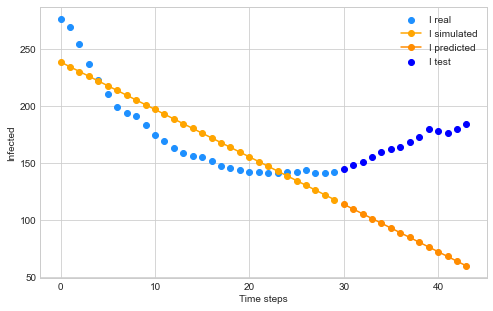

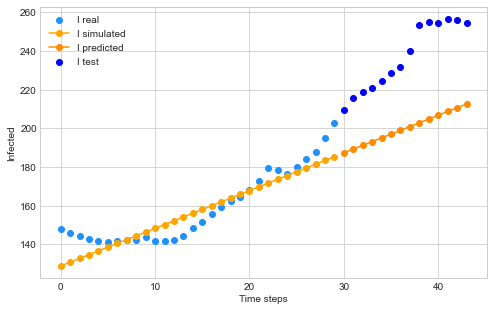

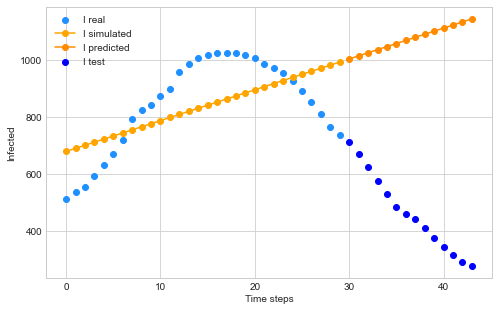

In [5]:
# create an object of the class
w = TrendExtrapolation(window_size=30, steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=1, # specify degree of the polynomial if necessary (default=1)
    data=train['Infected']) # univariate series

# get a random train and test window
window_train, window_test = w.random_windows()
# fit the model and get the predictions
I_simulated = w.fit_predict(window_train, degree=1, return_only_predictions=True)

# fit model and plot the results for 3 random windows
w.plot_windows(max_subplots=3)

* Note that in the last window plotted, predictions twist when they reach zero. This is an a posteriori correction of the predictions. It is necessary because it does not make sense to predict negative cases. In addition, if not applied, some metrics such as RSMLE could not be calculated.

Then, this type of model can be evaluated as follows on test windows:

In [6]:
# evaluate the model
poly_1_evaluation = w.evaluate()
# show the evaluation as DataFrame
pd.DataFrame(poly_1_evaluation).style.highlight_min(axis=1)

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,step_6,baseline_step_6,step_7,baseline_step_7,step_8,baseline_step_8,step_9,baseline_step_9,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.316675,0.043611,0.417310,0.084687,0.596034,0.124049,1.004941,0.162142,1.183255,0.199331,1.309876,0.235929,1.389025,0.272227,1.456920,0.308394,1.513319,0.344274,1.562657,0.379405,1.622266,0.413828,1.666495,0.447639,1.766197,0.480946,1.859952,0.513788
MAE,47.870257,8.182047,56.202846,16.160479,64.937292,24.018672,73.693195,31.754079,82.364483,39.404409,90.990784,47.030153,99.674418,54.559678,108.405727,61.934498,117.267676,69.226228,126.009333,76.326660,134.839868,83.291952,143.658577,90.162347,152.494527,96.757351,161.185426,103.124101
RMSE,76.243230,13.526104,89.243289,26.275096,102.772381,38.584679,116.429382,50.699196,130.005557,62.643802,143.762963,74.451858,157.712670,86.140224,171.845968,97.699949,186.128035,109.033965,200.486793,120.038560,214.920148,130.720121,229.377270,141.078679,243.842435,151.129153,258.127768,160.853240
MAPE,0.211373,0.034633,0.251677,0.068130,0.294827,0.101089,0.338759,0.133616,0.379389,0.166112,0.418660,0.198986,0.457246,0.231901,0.496429,0.265162,0.536714,0.298712,0.577558,0.332470,0.620016,0.366571,0.664034,0.401110,0.709616,0.435683,0.756628,0.470564


This was just an example of using the class defined above for any window_size and steps_ahead. The objective now is to get the window_size that minimizes the prediction error on horizon 14.

## Estimation of best window size

The objective now is to find the window size that provides the best results -in general- for predicting the future 14 days. A function to evaluate different window sizes is defined below.

In [7]:
def get_best_window_size(degree, minimize_on_step=14, verbose=False):
    """
    Get the best window size for a given degree of the polynomial
    """
    start_range = degree+1
    eval_window_size = {}

    for window_size in range(start_range, 60):
        if verbose:
            print(f'Evaluating TrendExtrapolation for window size {window_size}...')

        w = TrendExtrapolation(window_size=window_size, steps_ahead=14,
            curve_type='poly', # specify type of curve to fit to data
            degree=degree, # specify degree of the polynomial if necessary (default=1)
            data=train['Infected']) # univariate series
            
        evaluation_metrics = w.evaluate()
        
        window_error = evaluation_metrics['step_14']

        eval_window_size[f'window_size_{window_size}'] = window_error

    return eval_window_size

The window size for which the metrics provide the smallest error in step 14 is sought. For this purpose, polynomials of degree 1 to 4 are evaluated over the test windows, studying window sizes from (degree+1) to 59.

In [8]:
# evaluate per degree
eval_degree = {}

for degree in range(1, 5):
    print(f'Searching best window_size for degree = {degree}...')
    eval_degree[f'deg_{degree}'] = get_best_window_size(degree)
    display(pd.DataFrame(eval_degree[f'deg_{degree}']).style.highlight_min(axis=1))

Searching best window_size for degree = 1...


,window_size_2,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,1.004390,1.030840,1.044268,1.062653,1.138930,1.175628,1.215413,1.263788,1.313256,1.357760,1.405104,1.471601,1.523874,1.552803,1.570838,1.581402,1.594482,1.611741,1.615608,1.640844,1.661496,1.692107,1.731350,1.751686,1.782177,1.802919,1.818941,1.845217,1.859952,1.879334,1.886912,1.911939,1.910242,1.935940,1.945934,1.959389,1.970022,1.972886,1.982903,1.997422,1.996338,1.999093,2.011217,1.999263,1.991909,1.983258,1.981423,1.982935,1.985884,1.997077,1.998475,2.001385,2.016087,2.021722,2.023625,2.034099,2.039454,2.056105
MAE,75.458930,77.402625,79.774476,82.916437,86.857950,90.703128,94.578470,98.429696,102.196563,106.010432,109.737080,113.359437,116.826228,120.283047,123.551550,126.767622,129.961785,133.036691,136.047524,138.934688,141.751414,144.441363,147.034592,149.590767,151.949844,154.363754,156.654564,158.966430,161.185426,163.438806,165.672258,167.936914,170.162206,172.378771,174.611242,176.910696,179.076427,181.192978,183.152301,185.042445,186.829092,188.504964,190.151733,191.596043,193.116359,194.484162,195.786956,197.020478,198.159494,199.292018,200.254068,201.311765,202.250589,203.096476,203.907282,204.596194,205.255274,205.832190
RMSE,130.690953,131.099295,133.949096,138.310428,143.500335,149.026668,154.872084,160.894669,166.925549,172.860345,178.665300,184.337732,189.875903,195.280910,200.572632,205.716636,210.686916,215.509836,220.158934,224.640329,228.970890,233.113834,237.106051,240.938596,244.623425,248.190133,251.604711,254.926090,258.127768,261.240012,264.255589,267.197100,270.042189,272.821434,275.502081,278.114235,280.626022,283.061867,285.400616,287.664785,289.820038,291.896851,293.882662,295.774549,297.581252,299.281871,300.915515,302.459037,303.926777,305.333035,306.650113,307.896236,309.073036,310.167832,311.188280,312.120979,312.974586,313.758764
MAPE,0.344391,0.348778,0.360107,0.373619,0.388935,0.404128,0.419664,0.435604,0.451502,0.467925,0.483882,0.500066,0.514937,0.529065,0.542793,0.556868,0.571256,0.585784,0.600544,0.615450,0.630753,0.645695,0.660894,0.676639,0.691816,0.707764,0.723804,0.740188,0.756628,0.774048,0.791415,0.809016,0.827162,0.845546,0.863955,0.883395,0.902580,0.921166,0.939366,0.957340,0.974184,0.990692,1.007021,1.021715,1.037067,1.051169,1.064150,1.077244,1.089008,1.100140,1.110895,1.121144,1.130183,1.138975,1.146982,1.153286,1.159450,1.164229


Searching best window_size for degree = 2...


,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,2.396543,2.116058,2.053629,1.778761,1.607764,1.441523,1.364127,1.226966,1.226997,1.272382,1.318101,1.392476,1.443473,1.480930,1.508725,1.525090,1.537524,1.564841,1.595722,1.617899,1.663367,1.693325,1.700669,1.755182,1.807272,1.818112,1.861408,1.876066,1.893899,1.914652,1.929844,1.945973,1.970789,1.976557,1.991077,2.003156,2.013240,2.024149,2.027855,2.043957,2.063834,2.054312,2.076119,2.090119,2.087017,2.099537,2.122845,2.124809,2.132129,2.151178,2.147309,2.175621,2.180826,2.191587,2.207488,2.220743,2.221879
MAE,222.030592,177.194613,157.744405,135.376477,118.421617,104.545042,96.823357,92.560595,91.322127,92.238827,94.586512,97.199263,99.870692,102.404061,105.129700,107.994366,110.765367,113.747005,116.425357,119.204736,121.640572,124.195594,126.446337,129.028771,131.374505,133.560429,135.898056,138.089584,140.381633,142.367205,144.653601,146.483561,148.189304,149.918521,151.392958,152.905522,154.277704,155.609505,156.969706,158.081824,159.493593,160.810577,162.361590,164.016349,165.758981,167.693276,169.658120,171.476510,173.589981,175.766235,177.881432,180.226710,182.550341,184.891157,187.396316,189.874957,192.379043
RMSE,459.815318,342.356686,279.221446,235.656676,202.747059,178.235192,161.534424,151.229178,147.767420,148.949247,152.986556,158.127550,163.307694,168.382394,173.763103,179.295991,184.717205,190.186377,195.457092,200.629285,205.679431,210.640538,215.410965,220.073511,224.631600,228.831278,233.020014,237.101299,240.912604,244.603464,248.162009,251.446642,254.618275,257.573768,260.309786,262.900091,265.297322,267.545887,269.714705,271.711688,273.713349,275.601933,277.507088,279.427195,281.350034,283.323907,285.420021,287.535210,289.760784,292.131637,294.537194,297.092468,299.750799,302.487889,305.343759,308.273819,311.279672
MAPE,1.001891,0.785553,0.709075,0.622479,0.557481,0.494583,0.450947,0.418985,0.407867,0.408164,0.417404,0.430068,0.443397,0.454741,0.465320,0.476863,0.488193,0.500022,0.512246,0.525182,0.537580,0.551141,0.562955,0.576584,0.589580,0.602225,0.615757,0.629109,0.645704,0.661919,0.679936,0.695967,0.712096,0.728534,0.743974,0.760174,0.775230,0.790278,0.804070,0.817046,0.830472,0.842938,0.856025,0.868520,0.880282,0.892708,0.905318,0.915693,0.927246,0.938580,0.949445,0.960894,0.971546,0.982251,0.992988,1.002752,1.012327


Searching best window_size for degree = 3...


,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,3.710871,3.518146,3.473025,3.246259,3.216369,3.105258,2.880354,2.662621,2.482980,2.191930,1.976252,1.898500,1.813478,1.772053,1.787668,1.741723,1.763119,1.741906,1.732414,1.755448,1.767696,1.767097,1.836629,1.876251,1.921922,1.932748,1.944704,1.936333,1.939813,1.953925,1.966902,1.988278,2.005392,2.023183,2.045323,2.050977,2.080348,2.089894,2.104436,2.125431,2.111346,2.130937,2.130738,2.139522,2.136376,2.160927,2.174966,2.174050,2.171639,2.190002,2.164108,2.192729,2.181458,2.207035,2.187794,2.211571
MAE,1161.106452,804.860256,596.677399,485.204514,424.218130,361.940083,304.905698,261.154235,219.684266,181.696931,157.296335,141.088942,133.275615,128.210560,126.911048,127.453859,128.648742,130.367177,133.125954,136.447137,140.526794,144.861415,149.137409,153.376795,156.584742,159.643553,162.252256,165.044910,167.656730,169.992238,172.402635,174.299133,175.845450,177.539693,178.869322,180.219938,181.569834,182.918185,183.975974,184.979344,186.072244,187.123312,188.063191,189.358522,190.334820,191.394038,192.870223,193.793040,195.021533,196.179575,197.210038,198.118328,199.305441,200.152364,200.927105,201.665860
RMSE,3144.728416,1912.210080,1290.061608,992.190597,824.723331,684.065609,552.362353,440.203836,355.620516,294.292521,247.738272,218.943332,202.725604,195.420706,193.813112,196.913211,201.426201,205.741357,209.968189,214.087058,219.155105,224.564517,230.544256,236.658117,242.465103,247.657401,252.498723,257.426231,262.303246,267.164725,272.055358,276.672788,280.854769,284.780081,288.562903,291.899916,295.125235,298.223907,300.951079,303.737073,306.426997,308.961458,311.488763,314.015092,316.260493,318.550235,320.757625,322.694619,324.533553,326.379655,328.009753,329.610052,331.155432,332.701413,334.145690,335.512523
MAPE,5.466992,3.495274,2.613860,2.131729,1.896789,1.666432,1.439083,1.240979,1.031393,0.868166,0.751484,0.681469,0.653153,0.640787,0.639903,0.643356,0.652906,0.665007,0.681424,0.703221,0.728465,0.759036,0.788888,0.822236,0.849385,0.876883,0.901785,0.927723,0.953458,0.973687,0.995256,1.012147,1.028730,1.044164,1.057306,1.071770,1.083690,1.096825,1.107594,1.118564,1.131928,1.145807,1.161063,1.178267,1.192764,1.209676,1.230301,1.246344,1.264346,1.282909,1.300321,1.317354,1.338017,1.355959,1.375524,1.396916


Searching best window_size for degree = 4...


,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,4.451831,4.265900,4.138626,4.063110,3.949873,3.774589,3.764029,3.622895,3.620295,3.531370,3.416517,3.284370,3.131750,3.023877,2.803155,2.600309,2.555543,2.451927,2.420139,2.389487,2.380607,2.360495,2.402379,2.365519,2.390390,2.365345,2.361231,2.364106,2.411587,2.431084,2.469082,2.430314,2.466172,2.463312,2.457447,2.448366,2.482329,2.452309,2.505453,2.498353,2.514783,2.514686,2.498972,2.515033,2.517279,2.499507,2.490627,2.482953,2.474570,2.438828,2.466336,2.459938,2.465950,2.459696,2.482109
MAE,7375.942879,4040.653116,2783.999512,1975.219981,1554.960136,1286.904305,1067.498095,890.092060,740.132491,610.866626,500.233209,409.786778,344.914167,301.905260,253.349122,221.114793,203.551518,196.562911,196.431805,194.818917,192.367958,190.990000,189.662221,188.375837,189.547535,193.211965,196.433924,197.807103,199.632842,200.976003,203.304987,204.952571,206.803749,209.222387,212.294674,216.288750,220.312617,225.028789,228.930307,233.155090,237.151630,241.321488,245.444484,249.653174,253.610217,257.642255,260.724748,263.954631,266.559984,269.062984,271.776095,274.024886,276.641407,278.789766,281.622479
RMSE,23253.479447,11864.947651,7537.171912,5025.815593,3711.846138,2912.049755,2379.509880,1884.635862,1474.990227,1153.368167,909.986447,748.691501,624.856901,511.779548,406.980260,339.131774,301.790434,287.984807,291.014848,295.243111,294.471991,290.599690,287.170957,282.057275,283.023388,288.731304,296.309431,302.582956,308.772251,314.825820,320.099078,325.455162,331.153662,337.423247,344.171382,351.303659,358.704743,366.433756,374.181499,381.657540,389.293498,396.970425,404.465304,411.831506,419.048956,425.957747,432.248323,438.495478,444.511717,450.039487,455.501554,460.690522,465.609728,470.128845,474.613375
MAPE,36.411159,18.285572,12.262862,8.691779,6.957625,5.837827,5.073112,4.344330,3.591120,2.951647,2.368149,1.927449,1.598743,1.383667,1.211188,1.111435,1.048766,1.026272,1.028027,1.025949,1.030413,1.036845,1.055333,1.067479,1.087825,1.115659,1.135478,1.157108,1.178473,1.199965,1.233976,1.266359,1.301842,1.335435,1.372605,1.410144,1.452820,1.497943,1.535525,1.579838,1.618606,1.659409,1.696209,1.735601,1.770087,1.802887,1.836311,1.866100,1.892966,1.920042,1.951732,1.975992,2.007545,2.032661,2.066044


Show the evolution of each metric as the size of each window increases. The graphs on the left correspond to the results for degree 1, those on the right to those for degree 4.

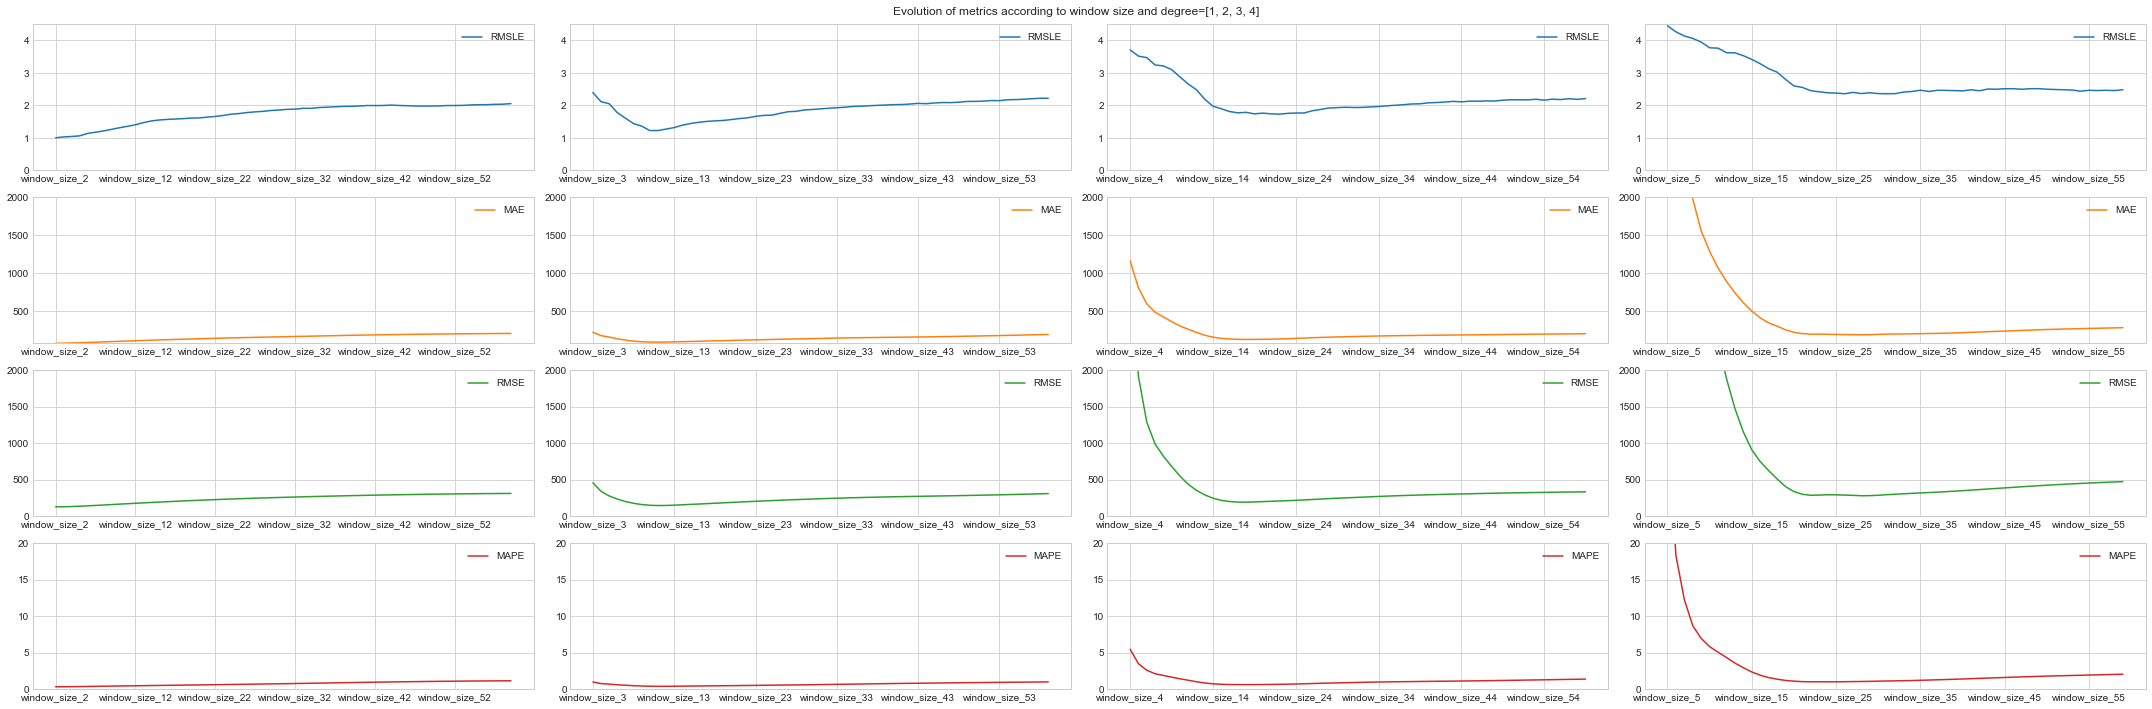

In [9]:
# metric evolution subplots
fig, axs = plt.subplots(4,4, figsize=(30, 10), tight_layout=True)

for i in range(1,5):
    pd.DataFrame(eval_degree[f'deg_{i}']).T.plot(ax=axs[:,i-1], subplots=True)
plt.setp(axs[0], ylim=(0,4.5))
plt.setp(axs[1], ylim=(75,2000))
plt.setp(axs[2], ylim=(0,2000))
plt.setp(axs[3], ylim=(0,20))

fig.suptitle('Evolution of metrics according to window size and degree=[1, 2, 3, 4]')
plt.show()

In conclusion:
- The results obtained when using polynomials of degree 1 differ from the rest: error increase with increasing window size. This means that it is best to assume that the trend of the last 2 days will continue over the next 14.
- If polynomials of degree 2 are used, a minimum is reached around window size 10. After that all errors increase. 
- For polynomials of degree 3 and 4, the errors seem to decrease the higher the number of points used. However, attention must be paid to the scale: all errors are excessively large. This phenomenon is explored below. 
- The minimum RMSLE obtained with polynomials of degree 2 is $1.22$, with degree 3 is $1.73$ and with degree 4 is $2.3$. These values are excessively large compared to what had been obtained.

An interesting comment to make is that the window size that gives the best results for polynomials of degree 1 is 2 past points. This window size is too small for a classical regression analysis to be meaningful and robust. However, it is convenient to take into account the time sense of the series and to understand this result as meaning that the trend of the next 14 points will be set by these past 2 days. 

### Comparison of polynomials under best window size

The errors for each polynomial degree are now compared using as window size the best one found in each case. That is, the error will be the minimum possible for each polynomial. With this, the aim is to extract which polynomial provides the best predictions under the best conditions for it.

In [10]:
# retrieve best window sizes for each degree
best_window_sizes = [2, 10, 22, 26]

In [11]:
# for every evaluation saved, get the metrics for the best window size
best_metrics_per_degree = {}

# best_metrics_per_degree['baseline_ws_30'] = poly_1_evaluation['baseline_step_14']

deg = 1
for deg_eval, best_window_size in zip(eval_degree.values(), best_window_sizes):
    best_metrics_per_degree[f'deg_{deg}_ws_{best_window_size}'] = deg_eval[f'window_size_{best_window_size}']
    deg +=1

pd.DataFrame(best_metrics_per_degree).style.highlight_min(axis=1)

,deg_1_ws_2,deg_2_ws_10,deg_3_ws_22,deg_4_ws_26
RMSLE,1.004390,1.226966,1.732414,2.360495
MAE,75.458930,92.560595,133.125954,190.990000
RMSE,130.690953,151.229178,209.968189,290.599690
MAPE,0.344391,0.418985,0.681424,1.036845


**Some conclusions**

- The above is the minimum possible error that can be obtained for each polynomial degree used (from 1 to 4). By looking at these metrics and comparing them with the baseline metrics for the arbitrary window size used earlier (window_size=30) it can already be concluded that these types of models are not worth further study: The trivial model outperforms these models (considering RMSLE).

## Forecasts exploration


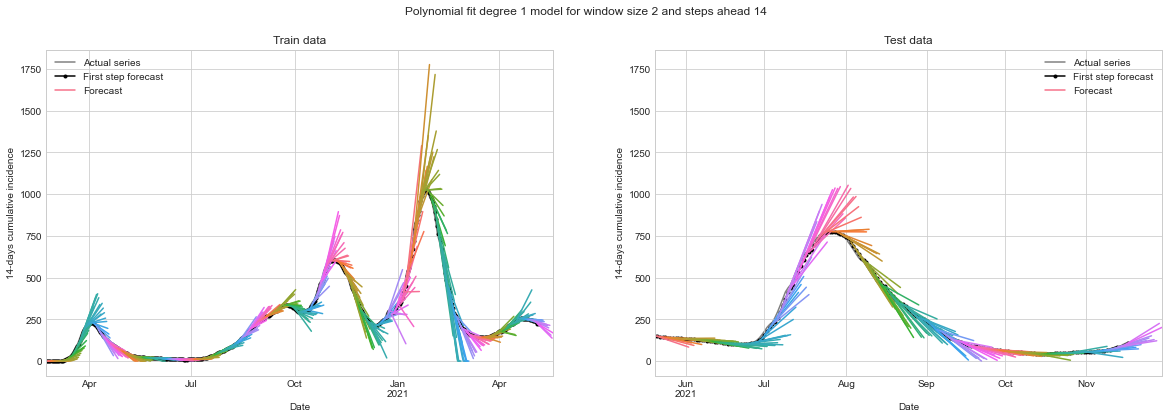

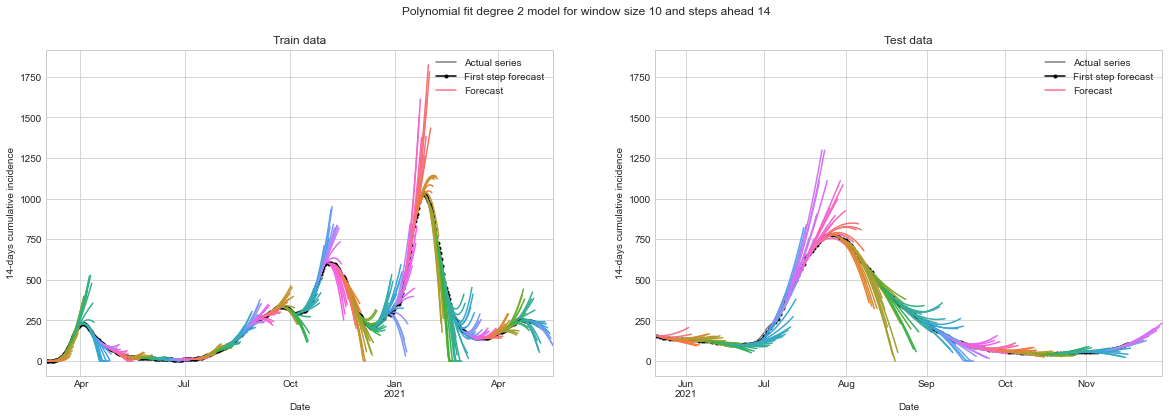

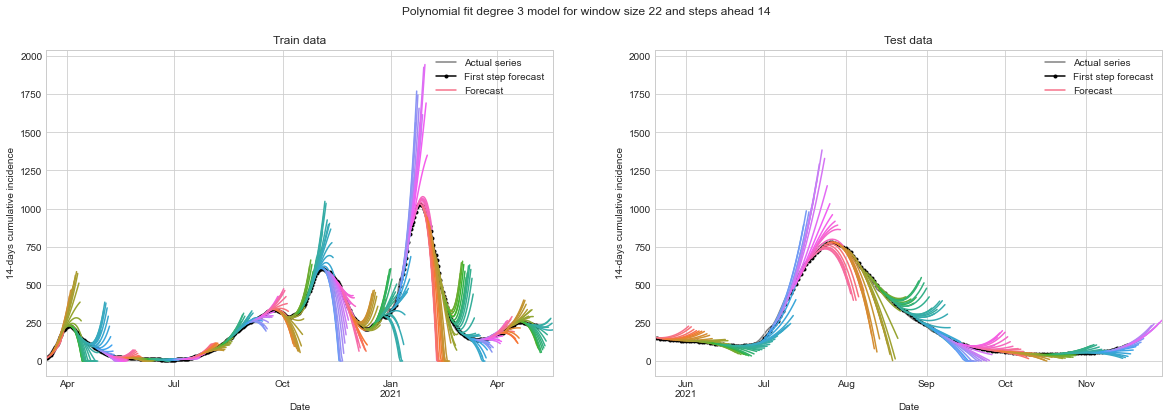

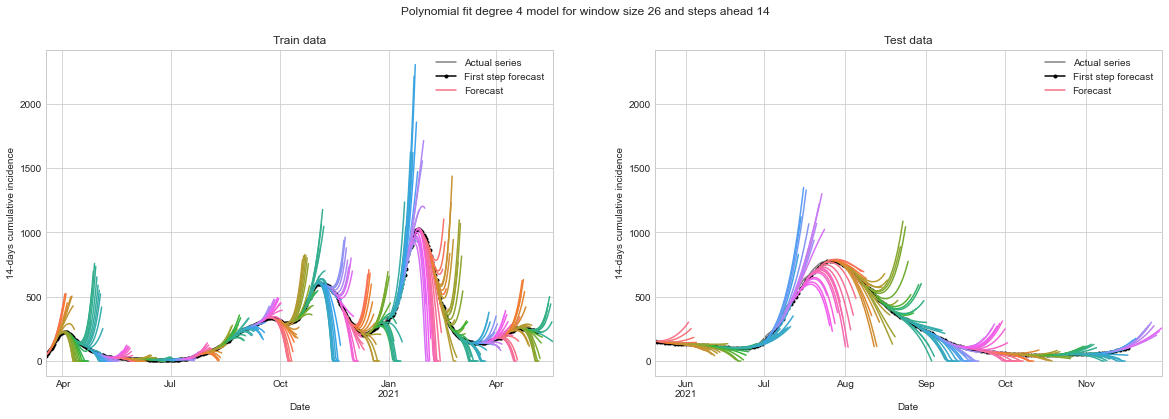

In [12]:
for degree, best_window_size in zip(range(1,5), best_window_sizes):
    w_train = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=train['Infected']) # univariate series

    test_data = pd.concat([ train['Infected'][-best_window_size:], test['Infected'] ])

    w_test = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=test_data) # univariate series

    y_fit_train = w_train.get_predictions_df(horizon=14, subset='train')
    y_fit_test = w_test.get_predictions_df(horizon=14, subset='test')  

    plot_all_predictions(y_fit_train, y_fit_test, df=df, model_name=f'Polynomial fit degree {degree}',window_size=best_window_size)

The predictions obtained are shown graphically in the figures above differentiated by polynomial degree. As expected from the results of the evaluation metrics, the predictions that are most faithful to the dynamics of the series are those generated with polynomials of degree $d=1$. As the degree of the polynomial increases, the predictions become more erratic and the behaviour of the polynomials unpredictable. This visual comparison reinforces that the model that best captures the dynamics are polynomials of degree 1 (with window size 2).

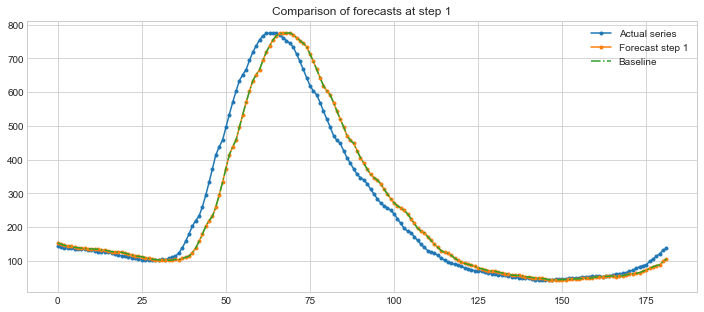

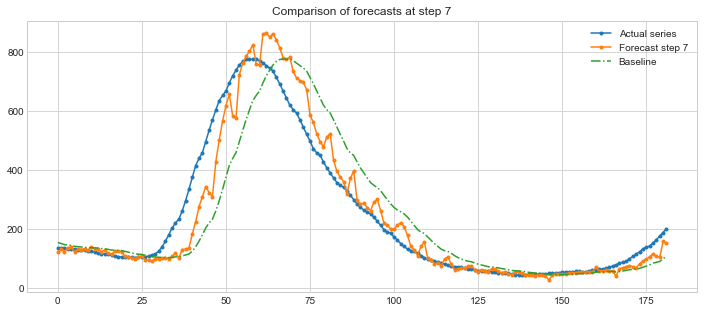

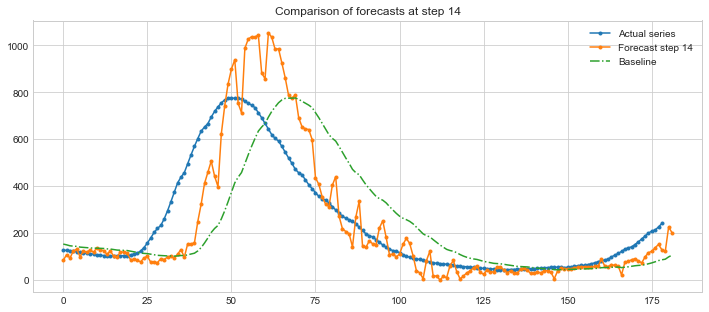

In [13]:
def compare_forecasts_at_step(y_fit, baseline, lower_ci=None, upper_ci=None, test_series=None, step=1):
    """ Compare the forecasts at a given step """

    forecasts_step = y_fit[f'y_step_{step}'].values
    base = baseline
    fig = plt.figure(figsize=(12, 5))

    plt.plot(test_series[step-1:len(y_fit)+step-1], marker='.', label='Actual series')
    plt.plot(forecasts_step, marker='.', label=f'Forecast step {step}')
    plt.plot(base, '-.', label='Baseline')

    # if prediction intervals are available, plot them
    try:
        lower_ci_step = lower_ci[f'ci_lower_step_{step}'].values
        upper_ci_step = upper_ci[f'ci_upper_step_{step}'].values
        plt.fill_between(range(len(forecasts_step)), lower_ci_step, upper_ci_step, color='lightgrey', alpha=0.5)
    except:
        pass

    plt.title(f'Comparison of forecasts at step {step}')
    plt.legend()
    plt.show()

for degree, best_window_size in zip(range(1,5), best_window_sizes):
    w_train = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=train['Infected']) # univariate series

    test_data = pd.concat([ train['Infected'][-best_window_size:], test['Infected'] ])

    w_test = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=test_data) # univariate series

    y_fit_train = w_train.get_predictions_df(horizon=14, subset='train')
    y_fit_test = w_test.get_predictions_df(horizon=14, subset='test') 

    # obtain data for the plots for both train and test data
    baseline_test = w_test.baseline[:,0]
    infected_test = test[w_test.window_size+1:]

    baseline_train = w_train.baseline[:,0]
    infected_train = train[w_train.window_size+1:]

    # compare_forecasts_at_step(y_fit_train, baseline=baseline_train, test_series=infected_train.values, step=14)
    for step in [1, 7, 14]:
        compare_forecasts_at_step(y_fit_test, baseline=baseline_test, test_series=infected_test.values, step=step)
    break # get only forecasts for poly degree 1

# Goodness of fit: the incorrect use of $R^2$

Once the above is noted, the goodness of fit is tested under the best conditions, i.e., with the optimal window_size.

This section is not intended to find the best configuration for a type of model, but to warn about the incorrect use of the metric $R^2 when extrapolating predictions. 
The reason for including this is that some studies can be found claiming that the best prediction model is polynomials with high degrees, justifying it with the $R^2$ metric. This metric measures the amount of variance of the dependent variable explained by the independent variable, therefore it measures how well is the fit, not the forecast accuracy. The use of this metric on training windows is justified in classical regression analysis, but has no place in time series, as it does not reflect the extrapolation capacity of a model.

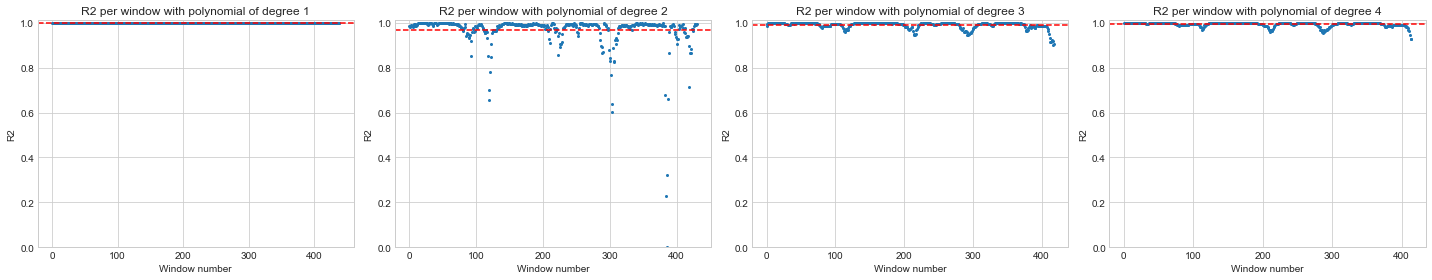

In [16]:
fig, axs = plt.subplots(1,4, figsize=(20, 4), tight_layout=True)

for degree,i in zip(range(1,5), range(0,4)):
    w = TrendExtrapolation(window_size=best_window_sizes[degree-1], steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    _ = w.get_all_predictions(horizon=14, degree=degree)

    axs[i].scatter(np.arange(0, len(w.train_r2)), w.train_r2, s=4)
    # plot horizontal line with the mean of w.train_r2
    axs[i].axhline(y=np.mean(w.train_r2), color='red', linestyle='--')
    # sns.histplot(w.train_r2, ax=axs[i], kde=True, bins=10)
    axs[i].set_title(f'R2 per window with polynomial of degree {degree}')
    axs[i].set_xlabel('Window number')
    axs[i].set_ylabel('R2')

plt.setp(axs, ylim=(0,1.01))
plt.show()

It can be seen how perfect values of $R^2$ are obtained for polynomials of degree 1, since 2 is the minimum number of points necessary to define a straight line, so in this case it does not provide any information. High values of $R^2$ ($R^2 > 0.8$) are found when interpolating with polynomials of degree 3 and 4. With polynomials of degree 2 there is more variability in the values: they move away from 1 when the infected series undergoes a pronounced change of trend. If this metric were used to evaluate the predictive capacity of the model, this observation would contradict the results obtained, since polynomials of degree 2 outperform polynomials of degree 3 and 4 in accuracy when extrapolating, according to the tables of evaluation. It is therefore concluded that the use of this metric in time series analysis is insufficient to evaluate the potential of a model and studies that praise it should be distrusted.

# Evaluation per degree under best $window\_size$

Here the evaluations are retrieved and displayed in tabular form.

In [17]:
base_dir = Path(os.getcwd()).parents[0]
path_to_store_results = os.path.join(base_dir, 'data', 'model-evaluation-results')

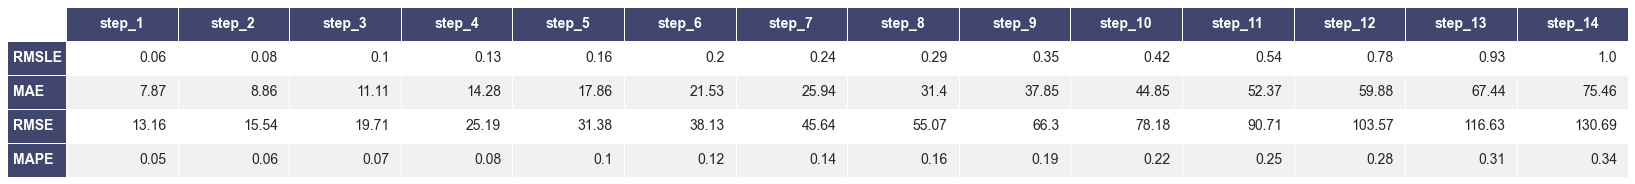

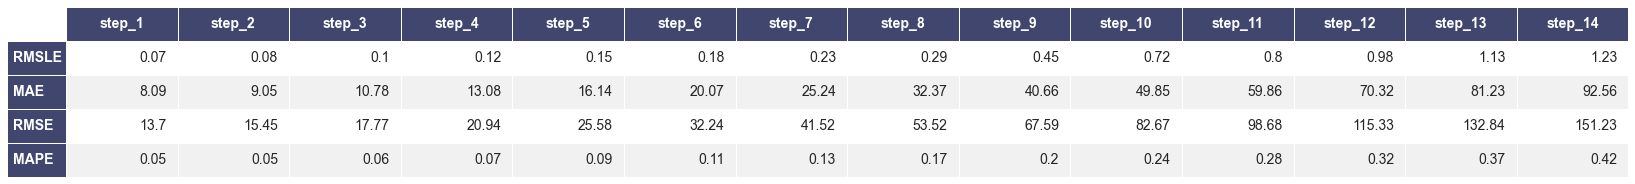

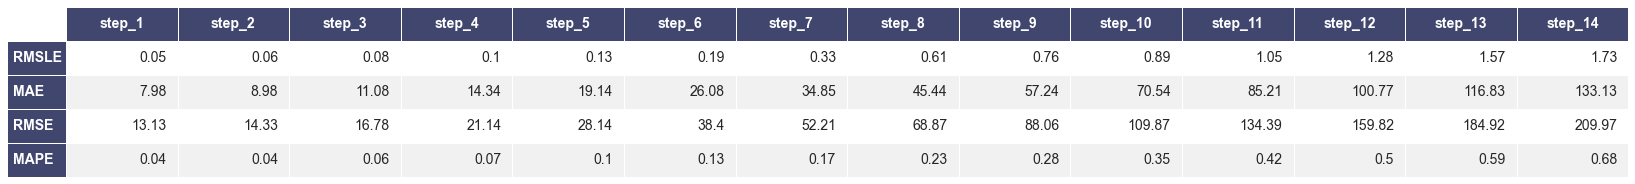

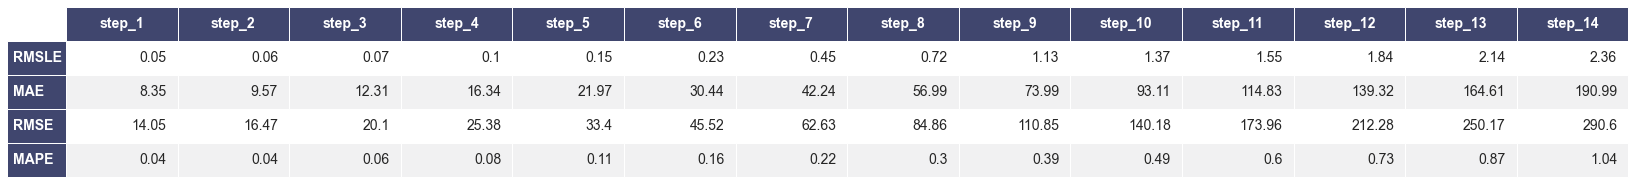

In [18]:
# get evaluation per degreee 
for degree,i in zip(range(1,5), range(0,4)):
    w = TrendExtrapolation(window_size=best_window_sizes[degree-1], steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    _ = w.get_all_predictions(horizon=14, degree=degree)

    # get eval
    eval = pd.DataFrame(w.evaluate()).T[::2].T

    # save eval to csv
    path_to_save_df = os.path.join(path_to_store_results, f"POLY-evaluation-degree-{degree}")
    eval.round(2).to_csv(path_to_save_df)

    # save evaluation df as figure
    path_to_save_image = os.path.join(path_to_store_results, f'POLY_evaluation_degree_{degree}.png')

    show_eval_table_and_save(eval, path_to_save_image)
    # print(eval.round(2).to_latex(header=[f'h={i}' for i in range(1,15)]))
    

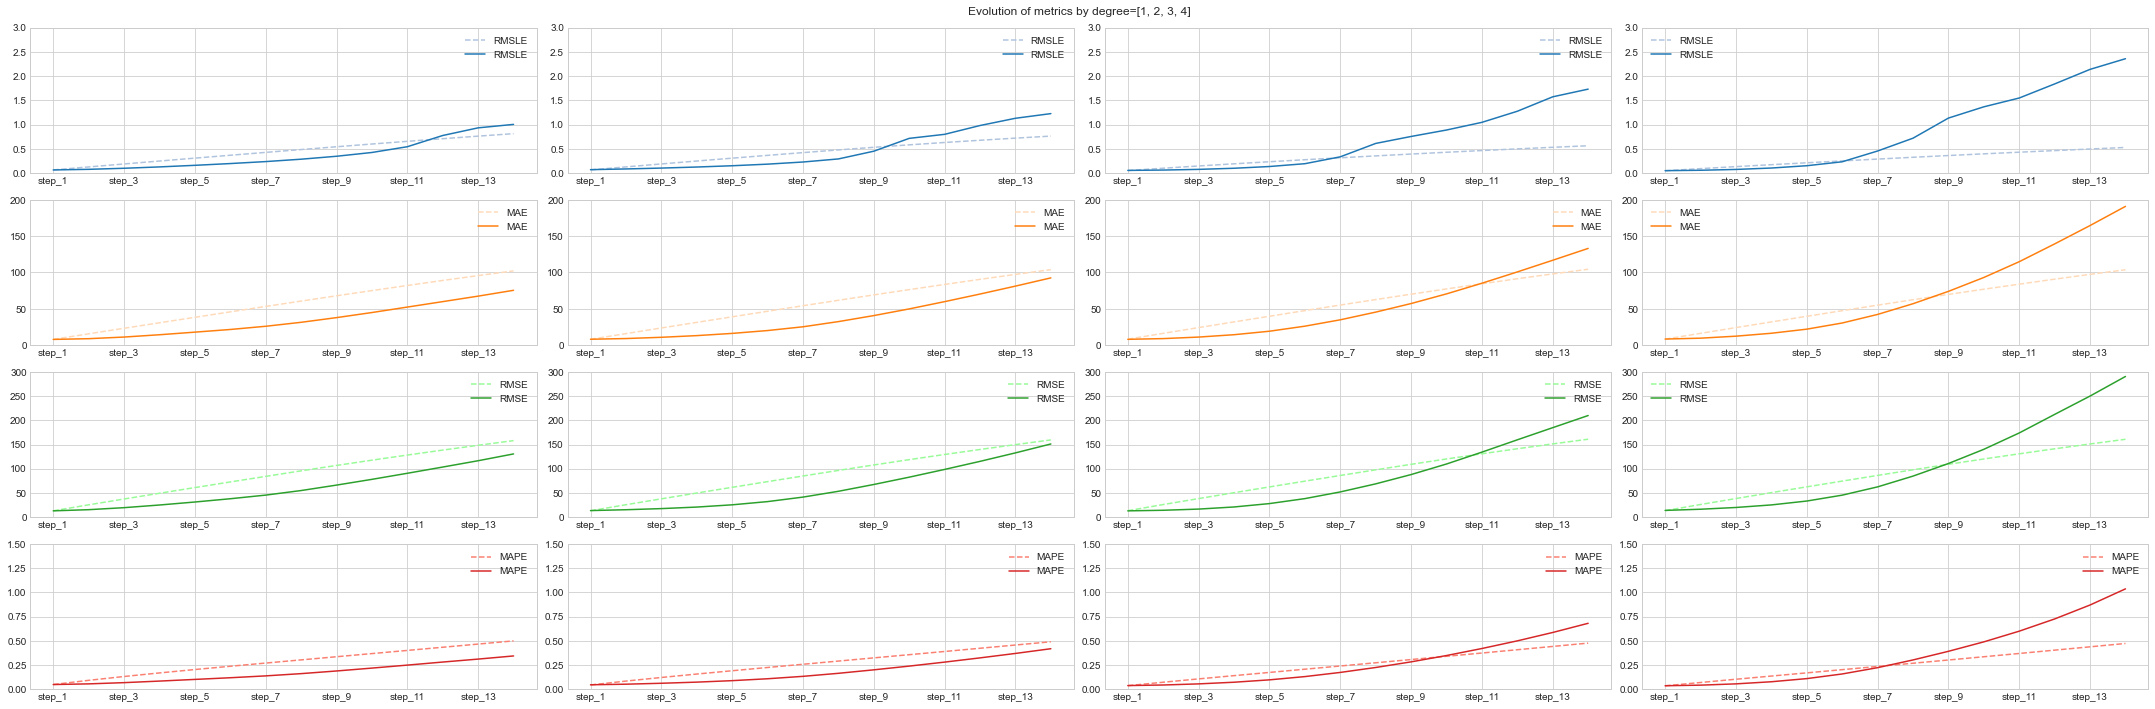

In [19]:
fig, axs = plt.subplots(4,4, figsize=(30, 10), tight_layout=True)
baseline_colors = ['lightsteelblue', 'peachpuff', 'palegreen', 'salmon']

for degree in range(1,5):
    
    w = TrendExtrapolation(window_size=best_window_sizes[degree-1], steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    w_eval = pd.DataFrame(w.evaluate())

    # metric evolution subplots
    w_eval.T.loc['baseline_step_1'::2,:].plot(ax=axs[:,degree-1], subplots=True, color=baseline_colors, linestyle='--')
    w_eval.loc[:,::2].T.plot(ax=axs[:,degree-1], subplots=True)

plt.setp(axs[0], ylim=(0,3))
plt.setp(axs[1], ylim=(0,200))
plt.setp(axs[2], ylim=(0,300))
plt.setp(axs[3], ylim=(0,1.5))
fig.suptitle('Evolution of metrics by degree=[1, 2, 3, 4]')
plt.show()

- The polynomials that give the best results are those of degree 1 for any future time instant considered. This completes the above analysis numerically.
-  The $\text{RMSLE}$ results for polynomials of degree 1 increase significantly from the 8-9 day predictions. Arguably, this type of model could predict with some - perhaps insufficient - accuracy up to 9 days in the future. The predictions of the trivial model outperform the regression model in accuracy from step 8-9 according to $\text{RMSLE}$ and in the rest of the metrics the evolution is very close for all future instants. For the rest of the cases studied, the trivial model outperforms the predictions generated, a fact that suggests discarding these methods.

# Residuals exploration

After fitting the regression models, it is important to validate the results to verify that the assumptions imposed in the definition are met.
The behaviour of the residuals is now studied by graphical exploration on the validation subset for polynomials of degree 1.

It is worth recalling that time series regression analysis often differs from traditional regression analysis because the residuals also form a time series and therefore tend to be correlated. This would violate one of the assumptions imposed in the definition, so one of the most important graphs to consider is the correlogram.

## Polynomial degree=1

In [20]:
w_train = TrendExtrapolation(window_size=best_window_sizes[0], steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=1, # specify degree of the polynomial if necessary (default=1)
    data=train['Infected']) # univariate series

w_test= TrendExtrapolation(window_size=best_window_sizes[0], steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=1, # specify degree of the polynomial if necessary (default=1)
    data=test['Infected']) # univariate series

In [21]:
# obtain data for the plots for both train and test data
baseline_test = w_test.baseline[:,0]
infected_test = test_data[w_test.window_size+1:]

baseline_train = w_train.baseline[:,0]
infected_train = train[w_train.window_size+1:]

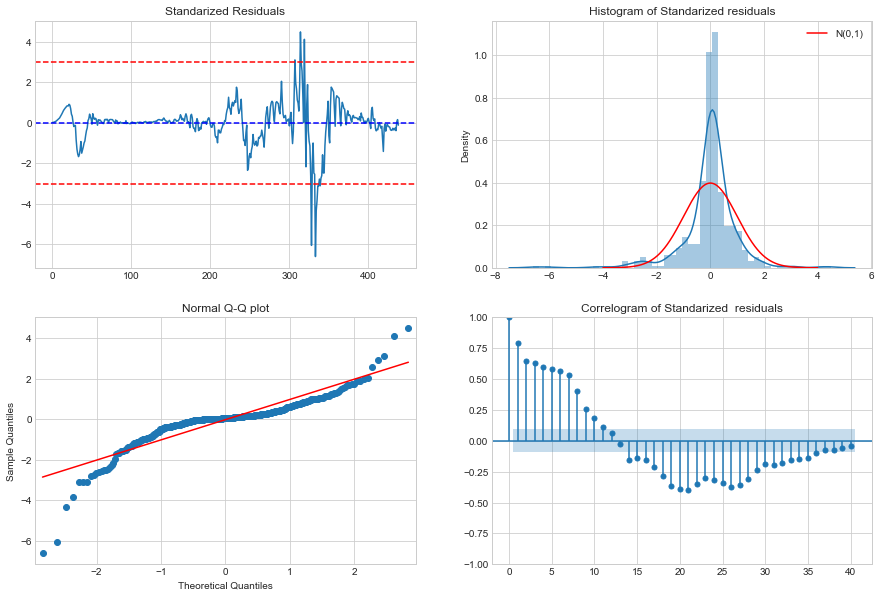

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,439.0,-0.014576,1.001141,-6.607612,-0.210458,0.062189,0.309138,4.493531,10.001005,-1.431739


In [22]:
residuals_train = w_train.get_residuals(horizon=14)
diagnostic_checking_residuals(residuals_train, standarized_residuals=True)
residuals_stats(standarize_residuals(residuals_train))

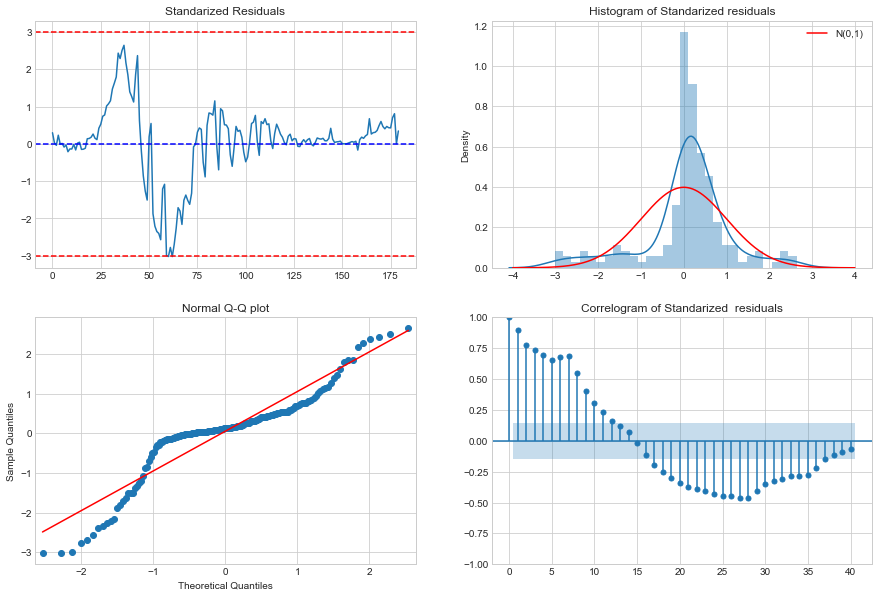

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,180.0,5.884825,113.876203,-343.091605,-9.244273,14.622876,53.672237,299.990127,2.014138,-0.779644


In [23]:
residuals_test = w_test.get_residuals(horizon=14)
diagnostic_checking_residuals(residuals_test, standarized_residuals=True)
residuals_stats(standarize_residuals(residuals_test))
residuals_stats(residuals_test)

Moreover, it is observed that the series of residuals shows a strong positive correlation in the short run. In addition, the residuals (unstandardised) have a mean of $5.88$ and a standard deviation of $113.88$. The line plot, histogram and Q-Q plot of the standardised residuals also show how the distribution of the standardised residuals is considerably far from a $\mathcal{N}(0,1)$. Moreover, the graph shows a rather high number of outliers identified during the residual study. 

These facts allow us to state that the hypotheses necessary for a regression analysis to be well defined and meaningful are not verified. This justifies the model's inability to predict accurately, as described above. 

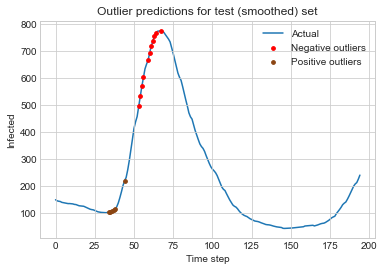

In [24]:
# predicted outliers in the test_ma set
standarized_residuals_test_ma = standarize_residuals(residuals_test)
outliers_low, = np.where(standarized_residuals_test_ma < -2)
outliers_high, = np.where(standarized_residuals_test_ma > 2)

test_ma = test.values
plt.plot(test_ma, label='Actual', zorder=0)
plt.scatter(outliers_low, test_ma[outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, test_ma[outliers_high], color='saddlebrown', s=14, label='Positive outliers')
test
plt.legend()
plt.title('Outlier predictions for test (smoothed) set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()

# Conclusions

Ultimately, the only configuration of interest found for linear regression models with polynomial curves is to take the degree of the polynomials equal to 1 for a window size equal to 2. That is, to model the evolution of the cumulative incidence as a function of the time instant $t$.
However, this is not sufficient to obtain quality predictions. The reason is that assuming that the dynamics and transmission of the virus depend exclusively on the time instant seems too simple and inadequate. 